In [5]:
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely 
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl

#import geemap.eefolium as emap
import folium
import os

In [6]:
DIR_img = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/data/'
DIR_label = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/labels/'
file_img = os.path.join(DIR_img,'scene2.tif')
file_lb = os.path.join(DIR_label,'label2.tif')

In [7]:
data_img = rio.open(file_img)
label_img = rio.open(file_lb)

In [11]:
data_img = data_img.read()
label = label_img.read()

In [13]:
print('shape of image',data_img.shape)
print('shape of label',label.shape)

shape of image (4, 35383, 25824)
shape of label (1, 35383, 25824)


In [14]:
patch_size = 256
img_height = data_img.shape[1]
img_width = data_img.shape[2]
number_of_vertical_tiles = img_height // 256
number_of_horizontal_tiles = img_width // 256

In [17]:
# Divide into patches
from geotile import GeoTile

gt = GeoTile(file_img)
gt_lab = GeoTile(file_lb)

In [19]:
# Save patch
DIR_data_patches = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/data/patches_data/'
os.makedirs(DIR_data_patches, exist_ok=True)
DIR_label_patches = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/labels/patches_label/'
os.makedirs(DIR_label_patches, exist_ok=True)

In [20]:
# to generate the tiles having no overlapping
gt.generate_tiles(DIR_data_patches, tile_x=256, tile_y=256, stride_x=256, stride_y=256)
gt_lab.generate_tiles(DIR_label_patches, tile_x=256, tile_y=256, stride_x=256, stride_y=256)

KeyboardInterrupt: 

In [66]:
# load data
im_0 = rasterio.open(os.path.join(DIR_data_patches,'tile_7424_4352.tif'))
lab_0 = rasterio.open(os.path.join(DIR_label_patches,'tile_7424_4352.tif'))

In [67]:
# Open image and label
def vis_patch(image, mask):
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].imshow(np.transpose(image, (1,2,0)))
    ax[1].imshow(np.transpose(mask, (1,2,0)))
    

In [68]:
x = im_0.read()
y = lab_0.read()

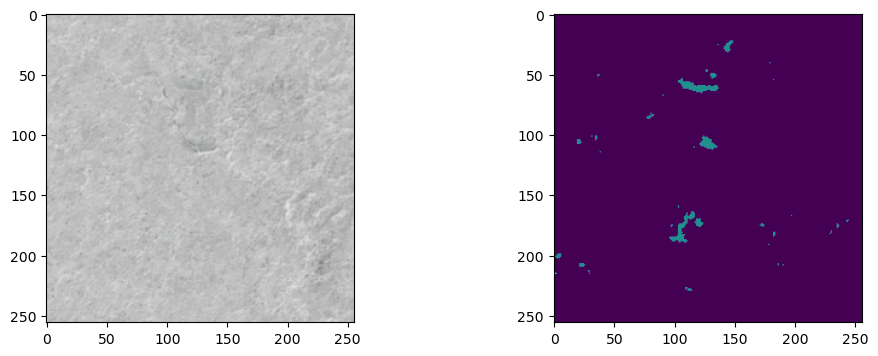

In [69]:
vis_patch(x,y)

Text(0.5, 1.0, 'Mask')

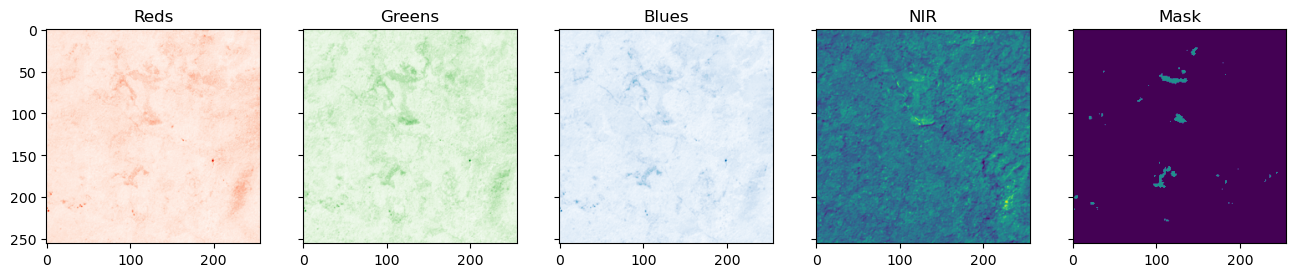

In [70]:
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize = (16,4))
img1 = ax1.imshow(x[0], cmap = 'Reds')
ax1.axis('on') 
ax1.set_title("Reds")

img2 = ax2.imshow(x[1], cmap = 'Greens')
ax2.axis('on')    
ax2.set_title("Greens")

img3 = ax3.imshow(x[2], cmap = 'Blues')
ax3.axis('on')
ax3.set_title("Blues")


img4 = ax4.imshow(x[3])
ax4.axis('on')
ax4.set_title("NIR")

msk = ax5.imshow(np.transpose(y, (1,2,0)))
ax5.set_title("Mask")

In [72]:
np.unique(y)

array([10, 30, 50], dtype=uint8)

In [4]:
import cv2
import tifffile as tiff

In [5]:
image = tiff.imread(file_img)
label = tiff.imread(file_lb)

In [6]:
print(image.shape)

(35383, 25824, 4)


In [7]:
patch_size = 256

In [8]:
SIZE_X = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch siz
SIZE_Y = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
#image = Image.fromarray(image)
print(SIZE_X)
print(SIZE_Y)
            

35328
25600


In [13]:
def crop_center(img, cropx, cropy):
    y, x, *_ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty + cropy, startx:startx + cropx, ...]

In [19]:
print(35383//2 -(35328//2))
print(25824//2 -(25600//2))

27
112


In [21]:
print(image[112:112+25600, 27:27+35328,:].shape)

(25600, 25797, 4)


In [ ]:
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [15]:
image_f = crop_center(image, 256, 256)
print(image_f.shape)

(256, 256, 4)


In [10]:
image_f = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
 #Try not to resize for semantic segmentation
image_f = np.array(image_f)  
print(image_f.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'crop'

In [ ]:
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)